In [1]:
# Imports and initialization

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1919810
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [2]:
# Problem constants

r_0 = 0.5
beta = np.array([1, 10])
alpha = 1.0


In [3]:
# Shallow neural networks for PINN

class PINN(nn.Module):
    
    def __init__(self, in_dim, h_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=h_dim),
            nn.Sigmoid(),
            nn.Linear(in_features=h_dim, out_features=out_dim, bias=False)
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [4]:
# Loss functions for residual PDE

# u: control
# v: state
# p: adjoint


# State PDE residual loss

def loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner):
    p_inner_pred = model_p(X_inner)
    u_inner_pred = torch.minimum(U_b_inner, torch.maximum(U_a_inner, -(1.0 / alpha) * p_inner_pred))
    v_inner_pred = model_v(X_inner)
    dvdX = torch.autograd.grad(
        v_inner_pred, X_inner,
        grad_outputs=torch.ones_like(v_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # v_x v_y
    dvdX_xX = torch.autograd.grad(
        dvdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # v_xx v_xy
    dvdX_yX = torch.autograd.grad(
        dvdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # v_yx v_yy
    laplace = (dvdX_xX[:,0] + dvdX_yX[:,1]) # v_xx + v_yy
    laplace = laplace.reshape(len(laplace), 1)
    loss_res = torch.mean((laplace + (u_inner_pred + Rf_inner) / Beta_inner) ** 2)
    return loss_res


# State PDE boundary loss

def loss_state_bd(model_v, X_bd, V_bd):

    bd_pred = model_v(X_bd)
    loss_bd = torch.mean((bd_pred - V_bd) ** 2)
    return loss_bd


# State PDE interface jump loss

def loss_state_ij(model_v, X_ij, Vj_ij, Normal_ij, Vnj_ij):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)
    ij_inner = torch.cat([X_ij[:,0:2], -1.0+0.0*X_ij[:,0:1]], dim=1)

    v_ij_outer = model_v(ij_outer)

    vx_ij_outer = torch.autograd.grad(
        v_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(v_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]


    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = normal_x * vx_ij_outer[:,0:1] + normal_y * vx_ij_outer[:,1:2]

    v_ij_inner = model_v(ij_inner)

    vx_ij_inner = torch.autograd.grad(
        v_ij_inner, ij_inner,
        grad_outputs=torch.ones_like(v_ij_inner),
        retain_graph=True,
        create_graph=True
    )[0]

    Normal_inner = normal_x * vx_ij_inner[:,0:1] + normal_y * vx_ij_inner[:,1:2]

    jump_pred = v_ij_outer - v_ij_inner
    loss_jump = torch.mean((jump_pred - Vj_ij)**2)

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Vnj_ij)**2)

    return loss_jump + loss_normal_jump


In [5]:
# Loss functions for adjoint PDEs

# Adjoint PDE residual loss

def loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner):

    v_inner_pred = model_v(X_inner)
    p_inner_pred = model_p(X_inner)
    dpdX = torch.autograd.grad(
        p_inner_pred, X_inner,
        grad_outputs=torch.ones_like(p_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # p_x p_y
    dpdX_xX = torch.autograd.grad(
        dpdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # p_xx p_xy
    dpdX_yX = torch.autograd.grad(
        dpdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # p_yx p_yy
    laplace = (dpdX_xX[:,0] + dpdX_yX[:,1]) #p_xx + p_yy
    laplace = laplace.reshape(len(laplace), 1)
    loss_res = torch.mean((laplace + (v_inner_pred - vd_inner) / Beta_inner) ** 2)
    return loss_res


# Adjoint boundary loss

def loss_adj_bd(model_p, X_bd, P_bd):
    p_bd_pred = model_p(X_bd)
    loss_bd = torch.mean((p_bd_pred - P_bd)**2)
    return loss_bd


# Adjoint interface jump loss

def loss_adj_ij(model_p, X_ij, Pj_ij, Normal_ij, Pnj_ij):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)
    ij_inner = torch.cat([X_ij[:,0:2], -1.0+0.0*X_ij[:,0:1]], dim=1)

    u_ij_outer = model_p(ij_outer)

    ux_ij_outer = torch.autograd.grad(
        u_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(u_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = normal_x * ux_ij_outer[:,0:1] + normal_y * ux_ij_outer[:,1:2]

    u_ij_inner = model_p(ij_inner)

    ux_ij_inner = torch.autograd.grad(
        u_ij_inner, ij_inner,
        grad_outputs=torch.ones_like(u_ij_inner),
        retain_graph=True,
        create_graph=True
    )[0]

    Normal_inner = normal_x * ux_ij_inner[:,0:1] + normal_y * ux_ij_inner[:,1:2]

    jump_pred = u_ij_outer - u_ij_inner
    loss_jump = torch.mean((jump_pred - Pj_ij)**2)

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Pnj_ij)**2)

    return loss_jump + loss_normal_jump

In [6]:
# Total loss function

def loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
         X_bd, V_bd, P_bd, X_ij, Vj_ij, Pj_ij, Normal_ij, Vnj_ij, Pnj_ij):
    loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner)
    loss_vb = loss_state_bd(model_v, X_bd, V_bd)
    loss_vij = loss_state_ij(model_v, X_ij, Vj_ij, Normal_ij, Vnj_ij)
    loss_pr = loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner)
    loss_pb = loss_adj_bd(model_p, X_bd, P_bd)
    loss_pij = loss_adj_ij(model_p, X_ij, Pj_ij, Normal_ij, Pnj_ij)
    loss_total = loss_vr + 2.0 * loss_vb + loss_vij + loss_pr + 10.0 * loss_pb + loss_pij
    return loss_total, loss_vr, loss_vb, loss_vij, loss_pr, loss_pb, loss_pij


In [7]:
# Problem parameters

# Exact solutions
def exact_u(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    phi = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    u = np.minimum(u_b(x, y), np.maximum(u_a(x, y), -(1.0/alpha) * phi))
    return u

def exact_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    v = np.power(x**2 + y**2, 1.5) / Beta  + (1.0 / beta[0] - 1.0 / beta[1]) * (r_0 ** 3) * (0.5 * (z + 1.0))
    return v

def exact_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    p = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    return p

# Desired state function
def vd(x, y, z):
    v = exact_v(x, y, z)
    laplace_beta_p = (-5.0 * alpha) * (2.0 * (x**4 + y**4 + 12.0 * (x**2) * (y**2)) - (16.0 + 2.0 * (r_0)**2) * (x**2 + y**2) + 4.0 * (r_0**2 + 1.0))
    return v + laplace_beta_p

# Right hand side of state-control PDE
def rhs_f(x, y, z):
    u = exact_u(x, y, z)
    return -9.0 * np.sqrt(x**2 + y**2) - u

# Normal vectors for points on interface
def normal_vector(x, y):
    dist = np.sqrt(x**2 + y**2)
    normal_x = x / dist
    normal_y = y / dist
    normal = np.hstack((normal_x, normal_y))
    return normal

# Normal derivative of v on the interface
def normal_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    temp = 3.0 * np.sqrt(x**2 + y**2) / Beta
    grad_x = temp * x
    grad_y = temp * y
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Normal derivative of p on the interface
def normal_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    grad_x = (-5.0 * alpha) * 2.0 * x * (y**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    grad_y = (-5.0 * alpha) * 2.0 * y * (x**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Lower and upper bound for admissible control
def u_a(x, y):
    return 0.0 * x - 1.0

def u_b(x, y):
    return 0.0 * x + 1.0


In [8]:
# Auxiliary functions

# Determine which region does (x, y) belong to
def sign_x(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = -1.0
    return z

# Uniform sampling
def uniform_sampling(dim, n):
    return 2.0 * np.random.rand(n**dim, dim) - 1.0


In [9]:
# Initialize training data

# Density of grid points
N_inner = 32

# Training points

# X_inner: points inside the domain
X_inner = uniform_sampling(2, N_inner)
x = X_inner[:, 0:1]
y = X_inner[:, 1:2]
z = sign_x(x, y)
Beta_inner = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
X_inner = np.hstack((X_inner, z))

# Problem parameters
vd_inner = vd(x, y, z)
Rf_inner = rhs_f(x, y, z)
U_a_inner = u_a(x, y)
U_b_inner = u_b(x, y)

# X_bd: points on the boundary, totally 4*N_inner points
dumy_one = np.ones((2 * N_inner,1))
lh_point = uniform_sampling(1, 2 * N_inner)
xx1 = np.hstack((lh_point, -1.0*dumy_one, dumy_one))
lh_point = uniform_sampling(1, 2 * N_inner)
xx2 = np.hstack((-1.0*dumy_one, lh_point, dumy_one))
lh_point = uniform_sampling(1, 2 * N_inner)
xx3 = np.hstack((dumy_one, lh_point, dumy_one))
lh_point = uniform_sampling(1, 2 * N_inner)
xx4 = np.hstack((lh_point, dumy_one, dumy_one))
X_bd = np.vstack([xx1, xx2, xx3, xx4])

# V_bd: state function values on the boundary, totally 4*N_inner points
x = X_bd[:,0:1]
y = X_bd[:,1:2]
z = 0.0 * x + 1.0
V_bd = exact_v(x, y, z)

# P_bd: adjoint function values on the boundary, totally 4*N_inner points
P_bd = exact_p(x, y, z)

# X_ij: points on the interior interface
theta = 2.0 * np.pi * np.random.rand(8 * N_inner, 1)
x_ij = 0.5 * np.cos(theta)
y_ij = 0.5 * np.sin(theta)
X_ij = np.hstack([x_ij, y_ij])

# Normal vectors on the interface
Normal_ij = normal_vector(x_ij, y_ij)

# Vj_ij: state function jump on the interior interface
Vj_ij = exact_v(x_ij, y_ij, 0.0 * x_ij + 1.0) - exact_v(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Vnj_ij: state function normal jump on the interior interface
Vnj_ij = beta[1] * normal_v(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_v(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Pj_ij: adjoint function jump on the interior interface
Pj_ij = exact_p(x_ij, y_ij, 0.0 * x_ij + 1.0) - exact_p(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Pnj_ij: adjoint function normal jump on the interior interface
Pnj_ij = beta[1] * normal_p(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_p(x_ij, y_ij, 0.0 * x_ij - 1.0)


In [10]:
# Convert numpy arrays to tensors and pass to training device

X_bd = torch.from_numpy(X_bd).requires_grad_(True).double().to(device)
V_bd = torch.from_numpy(V_bd).double().to(device)
P_bd = torch.from_numpy(P_bd).double().to(device)

X_inner = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
vd_inner = torch.from_numpy(vd_inner).double().to(device)
Rf_inner = torch.from_numpy(Rf_inner).double().to(device)
U_a_inner = torch.from_numpy(U_a_inner).double().to(device)
U_b_inner = torch.from_numpy(U_b_inner).double().to(device)
Beta_inner = torch.from_numpy(Beta_inner).double().to(device)

X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij = torch.from_numpy(Normal_ij).double().to(device)
Vj_ij = torch.from_numpy(Vj_ij).double().to(device)
Vnj_ij = torch.from_numpy(Vnj_ij).double().to(device)
Pj_ij = torch.from_numpy(Pj_ij).double().to(device)
Pnj_ij = torch.from_numpy(Pnj_ij).double().to(device)


In [11]:
# Model, optimizer and learning rates

# PINN model
model_v = PINN(3, 100, 1).to(device)
model_p = PINN(3, 100, 1).to(device)
print(model_v)
print(model_p)

# Optimizer
optimizer = torch.optim.Adam(
    list(model_v.parameters()) + list(model_p.parameters()), 
    lr=0.01)
max_iter = 60000

# Step size scheduler
def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 5000
    update_lr_2 = 15000
    update_lr_3 = 30000

    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 0.005
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 0.001
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005


PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)
PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)


In [12]:
# Training loop

model_v.train()
model_p.train()

loss_hist = []
pbar = trange(max_iter)

for step in pbar:

    lr_adjust(step, optimizer)

    # Backward and optimize
    optimizer.zero_grad()
    loss_total, loss_vr, loss_vb, loss_vij, loss_pr, loss_pb, loss_pij = \
        loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
             X_bd, V_bd, P_bd, X_ij, Vj_ij, Pj_ij, Normal_ij, Vnj_ij, Pnj_ij)
    loss_total.backward()
    optimizer.step()

    if step % 100 == 0:
        pbar.set_postfix({'loss': '{0:.5e}'.format(loss_total.item()),
                          'loss_vr': '{0:.5e}'.format(loss_vr.item()),
                          'loss_vb': '{0:.5e}'.format(loss_vb.item()),
                          'loss_vij': '{0:.5e}'.format(loss_vij.item()),
                          'loss_pr': '{0:.5e}'.format(loss_pr.item()),
                          'loss_pb': '{0:.5e}'.format(loss_pb.item()),
                          'loss_pij': '{0:.5e}'.format(loss_pij.item()),
                          'stepsize': '{0:.5e}'.format(optimizer.param_groups[0]['lr'])})
        loss_hist.append(loss_total.item())


100%|██████████| 60000/60000 [12:18<00:00, 81.25it/s, loss=2.20697e-03, loss_vr=1.38994e-03, loss_vb=4.46802e-06, loss_vij=3.83000e-05, loss_pr=6.97105e-04, loss_pb=2.38568e-06, loss_pij=4.88307e-05, stepsize=5.00000e-04]


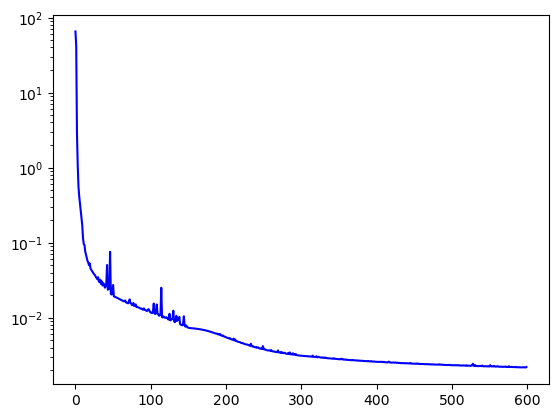

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_hist, 'b')
ax.set_yscale('log')
plt.savefig('ex2-alg1-training-loss.pdf')


In [14]:
# Testing trained model

# Number of test points
N_test = 256**2

# Absolute error

X_inner_test = qmc.LatinHypercube(d=2).random(256**2)
x_test = X_inner_test[:, 0:1]
y_test = X_inner_test[:, 1:2]
z_test = sign_x(x_test, y_test)
Exact_test = exact_u(x_test, y_test, z_test)
X_inner_test = np.hstack((X_inner_test, z_test))
X_inner_test_torch = torch.tensor(X_inner_test).double().to(device).requires_grad_(True)
u_a_test = u_a(x_test, y_test)
u_b_test = u_b(x_test, y_test)

with torch.no_grad():
    p_pred_torch = model_p(X_inner_test_torch)
    p_pred = p_pred_torch.detach().cpu().numpy()
    u_pred = np.minimum(u_b_test, np.maximum(u_a_test, -(1.0/alpha) * p_pred))

error = np.absolute(u_pred - Exact_test)
error_u = np.linalg.norm(error, 2) / np.sqrt(N_test)
print('Error u (absolute 2-norm): %e' % (error_u))

# Relative error

def eu_minus_polar(r, theta):
    val = 5.0 * (1.0 / alpha) * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[0]
    return r * (val)**2 if np.abs(val) < 1 else r

def eu_plus_polar(r, theta):
    val = 5.0 * (1.0 / alpha)  * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[1]
    return r * val**2 if np.abs(val) < 1 else r

def eu_plus_cart(x, y):
    val = 5.0 * (1.0 / alpha)  * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / beta[1]
    return val**2 if np.abs(val) < 1 else 1

norm_eu_minus_inner_squared = integrate.dblquad(eu_minus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
norm_eu_plus_whole_squared = integrate.dblquad(eu_plus_cart, -1.0, 1.0, -1.0, 1.0)
norm_eu_plus_inner_squared = integrate.dblquad(eu_plus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
norm_eu_plus_outer_squared = norm_eu_plus_whole_squared[0] - norm_eu_plus_inner_squared[0]
norm_eu = np.sqrt((norm_eu_minus_inner_squared[0] + norm_eu_plus_outer_squared) / 4.0) # Normalized by area

error_rel_u = error_u / norm_eu
print('Error u (relative 2-norm): %e' % (error_rel_u))


Error u (absolute 2-norm): 5.390836e-04
Error u (relative 2-norm): 1.853204e-03


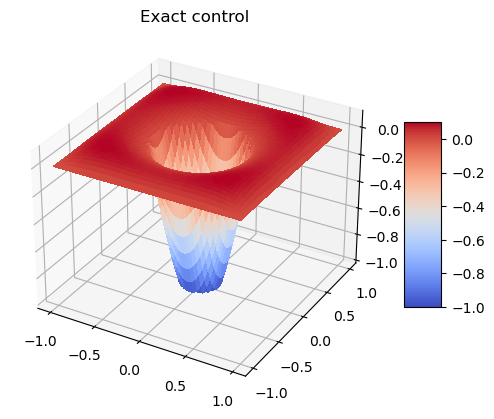

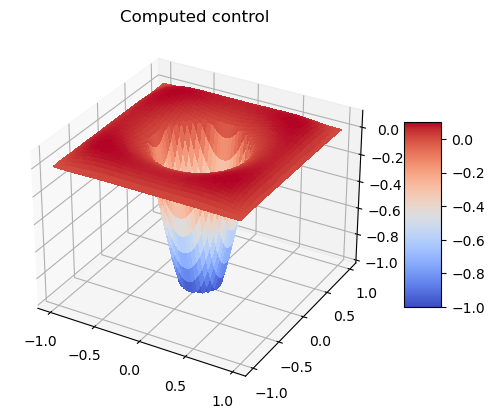

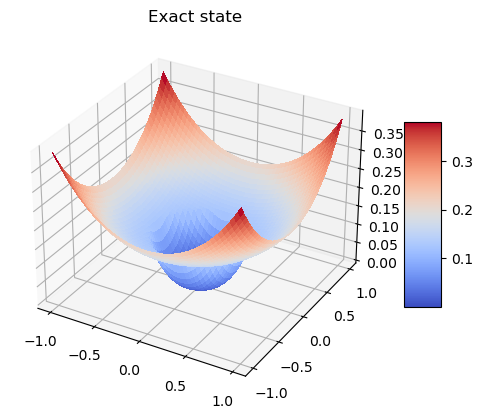

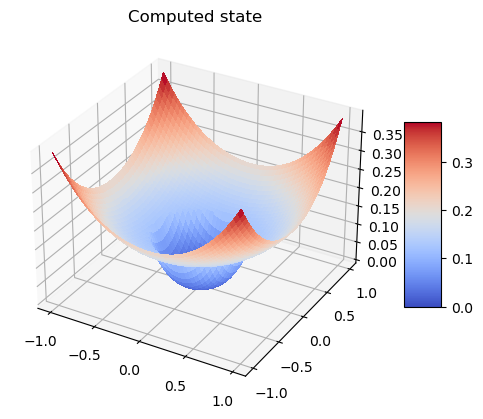

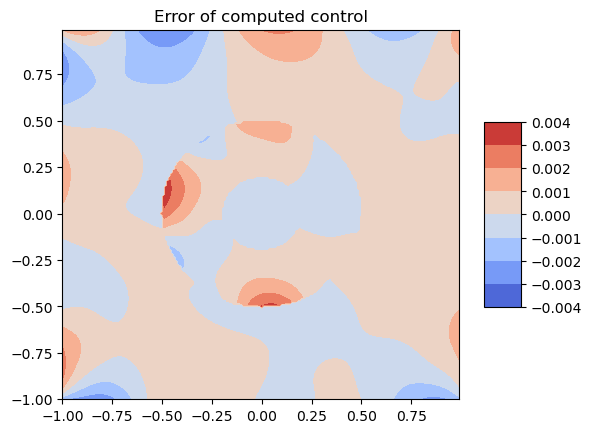

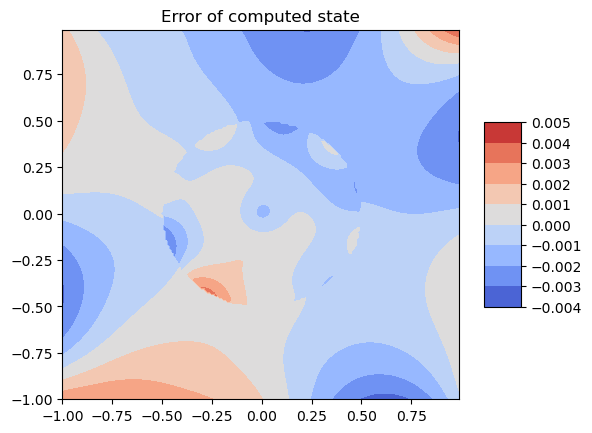

In [15]:
# Plot the solution

x_list = y_list = np.arange(-1, 1, 0.01)
x_mesh, y_mesh = np.meshgrid(x_list, y_list)

z_plot = 0.0 * x_mesh + 1.0
for i in range(len(z_plot)):
    for j in range(len(z_plot[i])):
        dist = np.sqrt(x_mesh[i, j]**2 + y_mesh[i, j]**2)
        if dist < r_0:
            z_plot[i, j] = -1.0

eu = exact_u(x_mesh, y_mesh, z_plot)
ev = exact_v(x_mesh, y_mesh, z_plot)

x_mesh_r = x_mesh.reshape(40000)
y_mesh_r = y_mesh.reshape(40000)
z_plot_r = z_plot.reshape(40000)
temp = np.stack((x_mesh_r, y_mesh_r, z_plot_r), axis=-1)
temp_torch = torch.tensor(temp).double().to(device)
pp = model_p(temp_torch).detach().cpu().numpy()
pv = model_v(temp_torch).detach().cpu().numpy()
pu = np.minimum(0.0 * pp + 1.0, np.maximum(0.0 * pp - 1.0, -(1.0/alpha) * pp))
pu = pu.reshape(200, 200)
pv = pv.reshape(200, 200)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_eu = ax.plot_surface(x_mesh, y_mesh, eu, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.title.set_text('Exact control')
fig.colorbar(surf_eu, shrink=0.5, aspect=5)
plt.savefig('ex2-alg1-exact-u.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pu = ax.plot_surface(x_mesh, y_mesh, pu, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.title.set_text('Computed control')
fig.colorbar(surf_pu, shrink=0.5, aspect=5)
plt.savefig('ex2-alg1-computed-u.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_ev = ax.plot_surface(x_mesh, y_mesh, ev, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.title.set_text('Exact state')
fig.colorbar(surf_ev, shrink=0.5, aspect=5)
plt.savefig('ex2-alg1-exact-y.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pv = ax.plot_surface(x_mesh, y_mesh, pv, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.title.set_text('Computed state')
fig.colorbar(surf_pv, shrink=0.5, aspect=5)
plt.savefig('ex2-alg1-computed-y.pdf')

fig, ax = plt.subplots()
surf_u_diff = ax.contourf(x_mesh, y_mesh, pu - eu, cmap=cm.coolwarm, antialiased=False)
fig.colorbar(surf_u_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed control')
plt.savefig('ex2-alg1-u-error.pdf')

fig, ax = plt.subplots()
surf_v_diff = ax.contourf(x_mesh, y_mesh, pv - ev, cmap=cm.coolwarm, antialiased=False)
fig.colorbar(surf_v_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed state')
plt.savefig('ex2-alg1-y-error.pdf')

In [16]:
# Save model, loss log and data set

model_filename = "results/ex2_alg1_trained_model.pt"
torch.save({"model_v_state_dict": model_v.state_dict(),
            "model_p_state_dict": model_p.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()}, model_filename)

csvfile = open("results/ex2_alg1_loss_hist.csv", 'w')
writer = csv.writer(csvfile)
writer.writerow(loss_hist)
csvfile.close()

data_filename_train = "results/ex2_alg1_data_train.npz"
np.savez(data_filename_train, X_inner=X_inner.cpu().detach().numpy(), X_ij=X_ij.cpu().detach().numpy())

data_filename_test = "results/ex2_alg1_data_test.npz"
np.savez(data_filename_test, X_inner_test=X_inner_test)


In [17]:
# Load trained model

# model_v = PINN(3, 100, 1).to(device)
# model_p = PINN(3, 100, 1).to(device)
# optimizer = torch.optim.Adam(
#     list(model_v.parameters()) + list(model_p.parameters()),
#     lr=0.001)

# model_filename = "results/ex2_alg1_trained_model.pt"
# checkpoint = torch.load(model_filename)
# model_v.load_state_dict(checkpoint['model_v_state_dict'])
# model_p.load_state_dict(checkpoint['model_p_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
